In [28]:
import re
import string
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import Model,save_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.layers import Dense,Concatenate,LSTM,Embedding,Input,add,Dropout

In [5]:
captions_list=[]
with open('/kaggle/input/flickr8k/captions.txt','r') as file:
    for line in file:
        captions_list.append(line)

captions_list.pop(0)
captions_list[0],captions_list[100],len(captions_list)

('1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1024138940_f1fefbdce1.jpg,Two different breeds of brown and white dogs play on the beach .\n',
 40455)

In [6]:
captions_dict={}
for cap in captions_list:
    try:
        img,caption=cap.split('.jpg,')
        captions_dict[img+'.jpg']=caption
    except:
        print(cap)        

In [80]:
def clean_text(text):
    text=text.lower()
    cleaned_text = re.sub(r'\n', '', text)
    cleaned_text = re.sub(r'[^A-Za-z ]','',cleaned_text)
    return 'sos'+' '+cleaned_text+' '+'eos'

In [81]:
for img,cap in captions_dict.items():
    captions_dict[img]=clean_text(captions_dict[img])

In [9]:
xception_model=Xception(include_top=False,pooling='avg')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model=Model(inputs=xception_model.input,outputs=xception_model.output)

In [18]:
#img_enc=[]
#for img in captions_dict.keys():
#    img=image.load_img('/kaggle/input/flickr8k/Images/'+str(img),target_size=(299, 299))
#    x = image.img_to_array(img)
#    x = np.expand_dims(x, axis=0)
#    x = preprocess_input(x)
#   img_enc.append(model.predict(x))

In [13]:
#with open('/kaggle/working/encoding.pkl','wb') as f:
#    pickle.dump(img_enc,f)

In [12]:
with open('/kaggle/input/encoder/encoding.pkl','rb') as f:
    img_enc = pickle.load(f)

In [14]:
encodings={}
for img,enc in zip(captions_dict.keys(),img_enc):
    encodings[img]=enc.reshape(2048,)

In [82]:
tokenizer=Tokenizer(oov_token='<unk>')
tokenizer.fit_on_texts(list(captions_dict.values()))
vocab_len=len(tokenizer.word_index)+1
vocab_len

4478

In [83]:
seq_lens=[len(cap.split(' ')) for cap in captions_dict.values()]
max(seq_lens),min(seq_lens)

(42, 6)

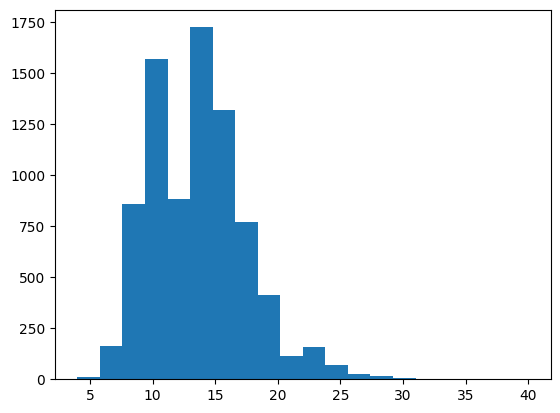

In [17]:
plt.hist(seq_lens,bins=20)
plt.show()

In [84]:
def DatasetGenerator(captions_dict,encodings,tokenizer,max_len=26,vocab_len=4478):
    while 1:
        for key, caption in captions_dict.items():
            encoding = encodings[key]
            in_img, in_seq, output_ = Create_Sequences(tokenizer, max_len, caption.replace('  ',' ').split(' '), encoding,vocab_len)
            yield ((in_img, in_seq), output_)

def Create_Sequences(tokenizer, max_len, caption, encoding,vocab_len):
    x1,x2,y=[],[],[]
    
    seq = tokenizer.texts_to_sequences([caption])[0]
        
    for i in range(1, len(seq)):
        in_seq, out_seq = seq[:i], seq[i]
            
        in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
            
        out_seq = to_categorical([out_seq], num_classes=vocab_len)[0]
            
        x1.append(encoding) 
        x2.append(in_seq)  
        y.append(out_seq)  
            
    return np.array(x1), np.array(x2), np.array(y)

In [86]:
input1 = Input(shape=(2048,))
e_img1 = Dropout(0.4)(input1)
e_img2 = Dense(units=256,activation='relu')(e_img1)

input2 = Input(shape=(26,))
e_seq1 = Embedding(vocab_len, 256,mask_zero=True)(input2)
e_seq2 = Dropout(0.4)(e_seq1)
e_seq3 = LSTM(256)(e_seq2)

decoder_in = add([e_img2,e_seq3])
decoder1 = Dense(128, activation='relu')(decoder_in)
decoder_out = Dense(vocab_len, activation='softmax')(decoder1)

model=Model(inputs=[input1,input2],outputs=decoder_out)
model.compile(loss='categorical_crossentropy', optimizer='adam')

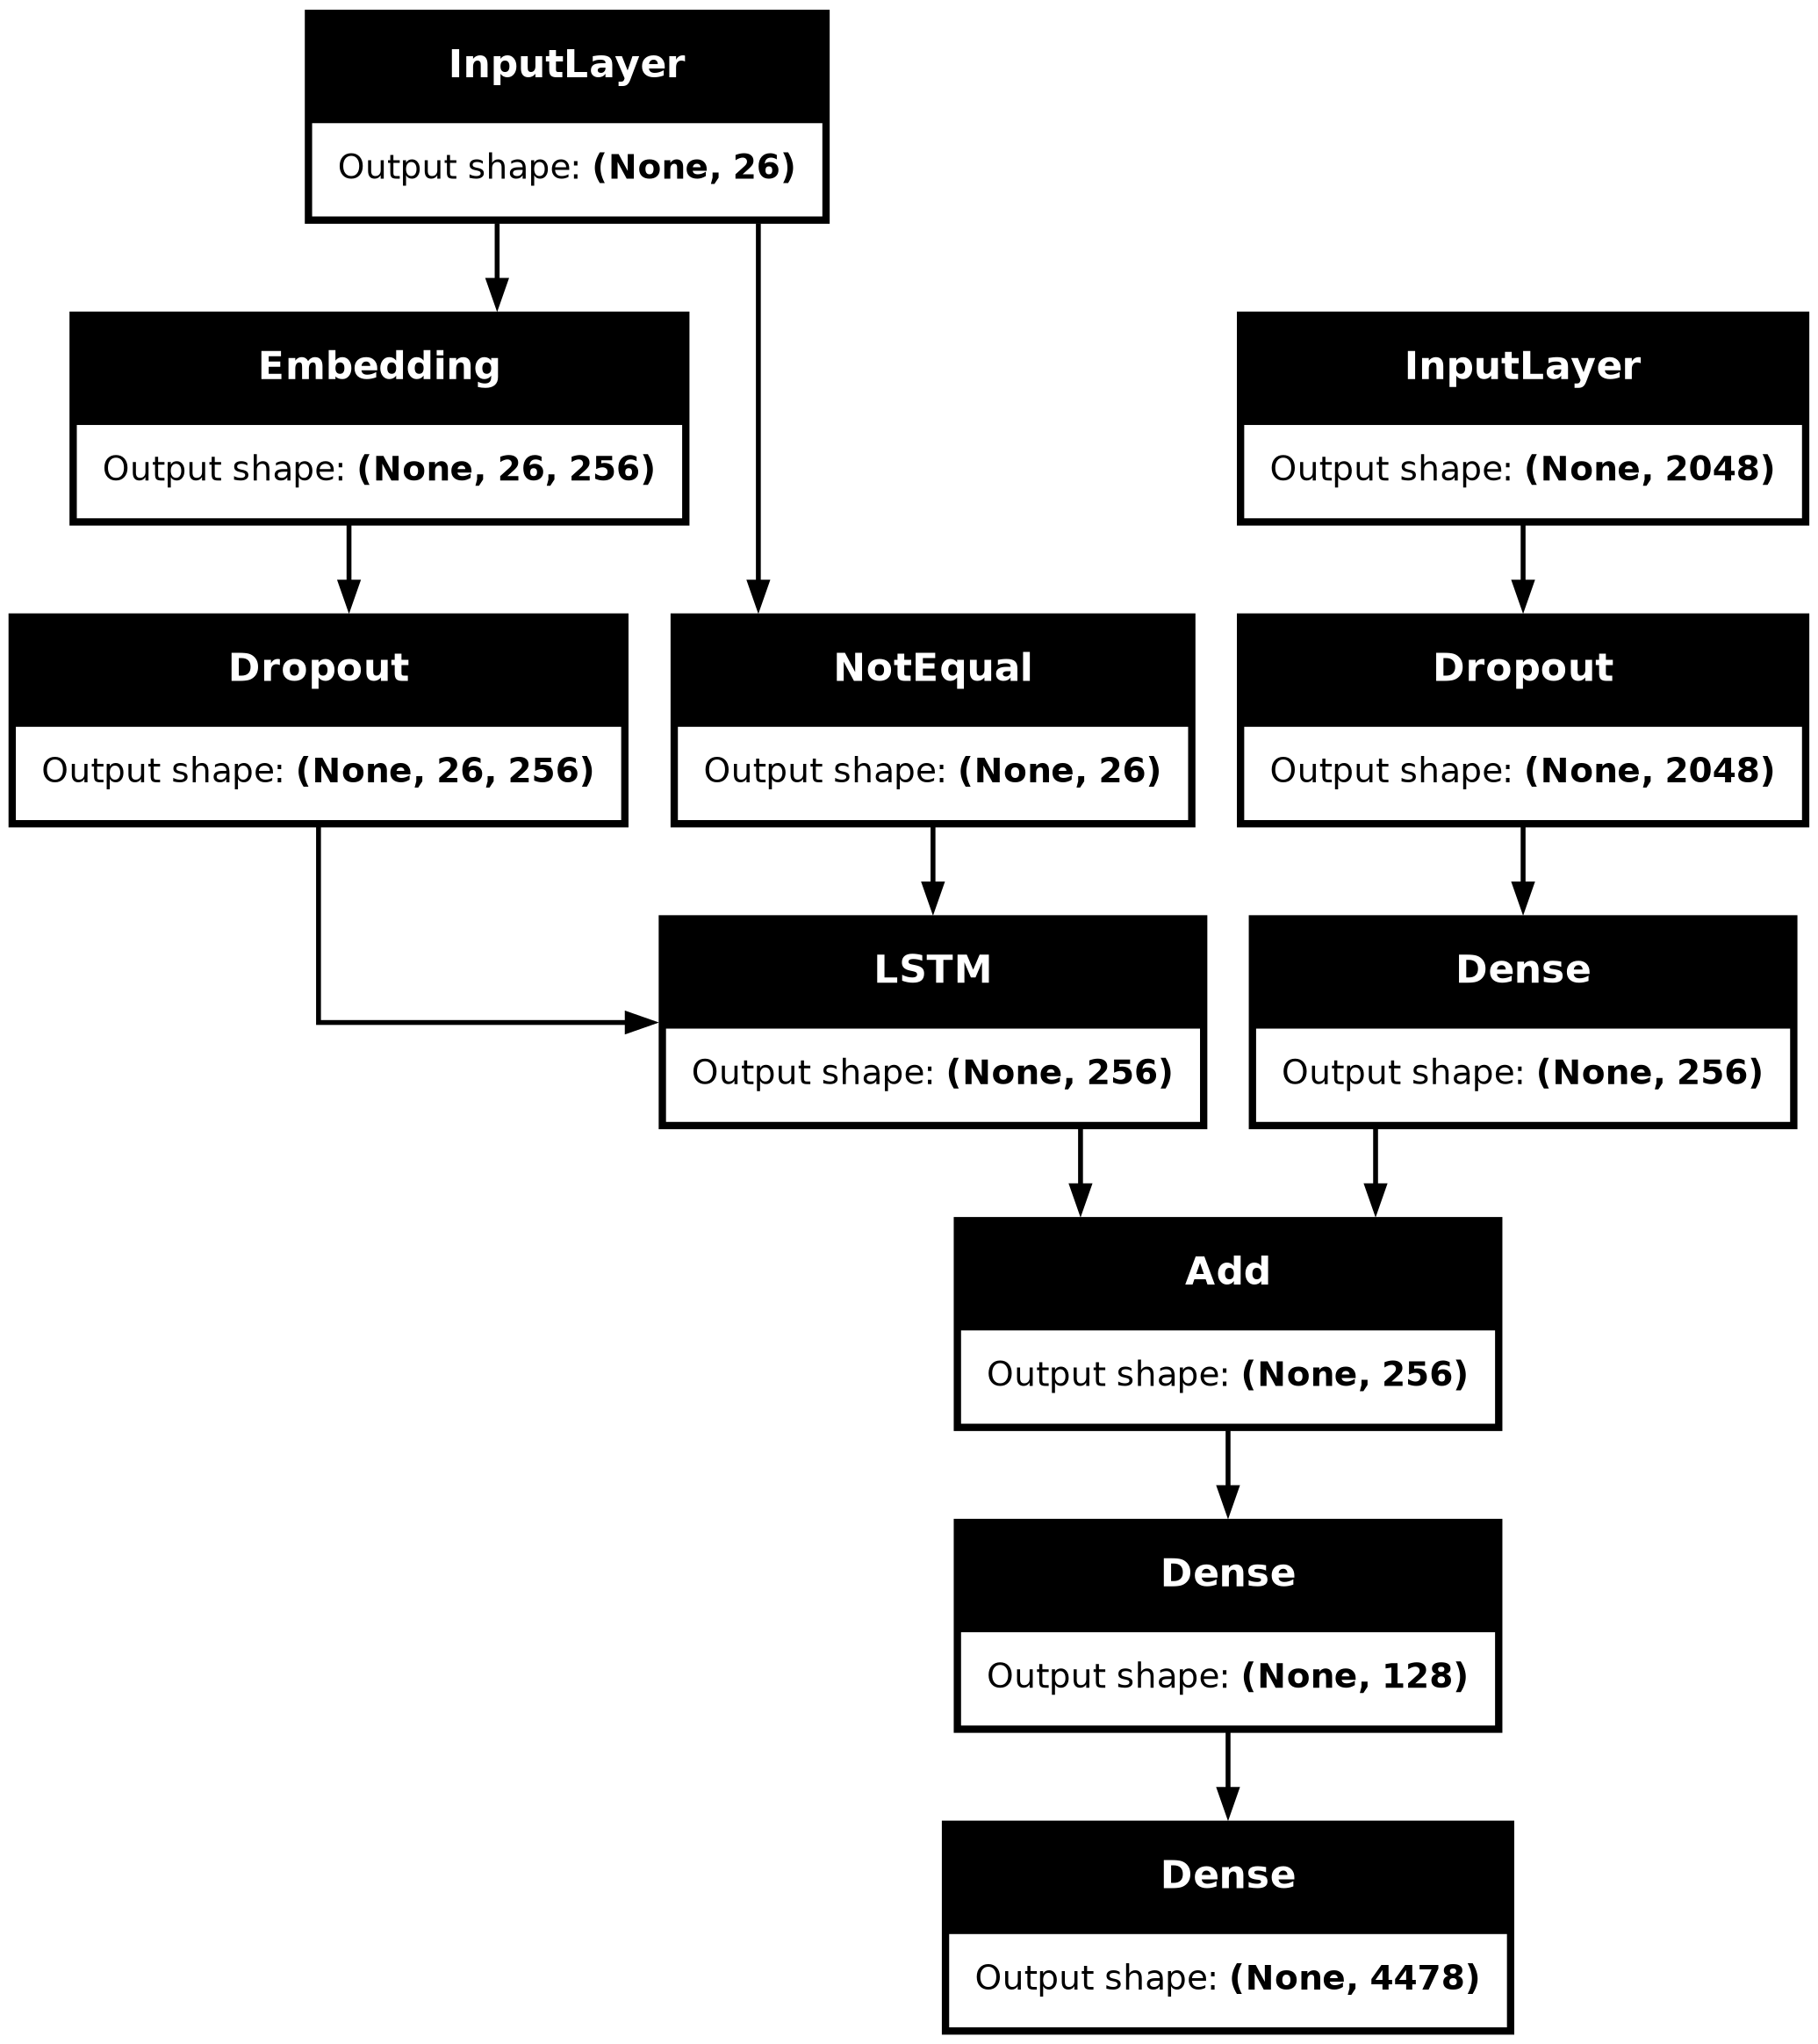

In [123]:
plot_model(model, to_file='model.png', show_shapes=True)

In [122]:
generator = DatasetGenerator(captions_dict,encodings,tokenizer)
model.fit(generator, epochs=5, steps_per_epoch= len(captions_dict)//64, verbose=1)

Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 2.2741
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 2.2510
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 2.4013
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 2.3866
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 2.3067


In [129]:
model.save('model.h5')

In [88]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length=26):
    in_text = 'sos'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([np.array([photo]), np.array(sequence)])
        pred = np.argmax(pred, axis=-1)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        
        in_text += ' ' + word
        
        if word == 'eos':
            break
    
    return in_text

In [126]:
generate_desc(model, tokenizer, encodings['1057251835_6ded4ada9c.jpg'], max_length=26)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


'sos sos white dog running through the beach eos'

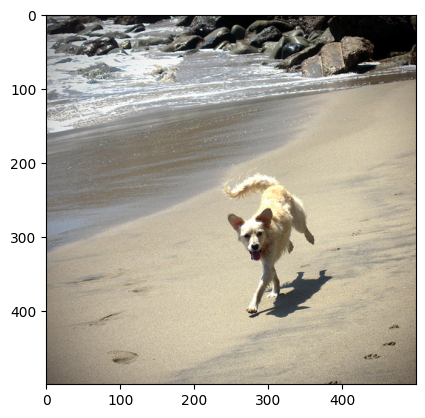

In [128]:
img=plt.imread('/kaggle/input/flickr8k/Images/1057251835_6ded4ada9c.jpg')
plt.imshow(img)
plt.show()